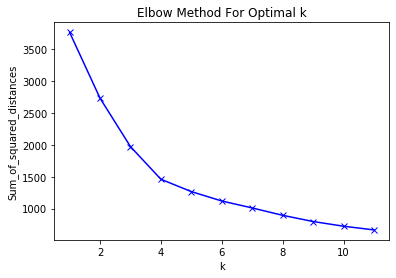

[3 3 3 ... 2 2 2]
(879, 3)
(879,)
(377, 3)
(377,)
['Low' 'Low' 'Meduim' 'Meduim' 'LowA']
170        Low
964        Low
573     Meduim
371     Meduim
1153      LowA
Name: Label, dtype: object
DecisionTrees's Accuracy:  0.9787798408488063
DecisionTrees's Accuracy:  0.9893899204244032


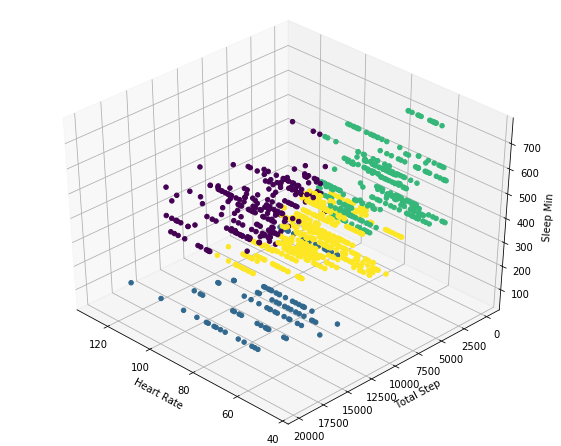

In [20]:
import datetime
import pandas as pd
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from firebase_admin import storage
from datetime import date, timedelta
import urllib.request, json 
import time
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import os
import csv
from IPython.display import display
from Model import trainData
import random

In [21]:
cred = credentials.Certificate("serene-2dfd6-firebase-adminsdk-gfc6o-a312184978.json")
app = firebase_admin.initialize_app(cred ,  {
    'storageBucket': 'serene-2dfd6.appspot.com',
}, name='[DEFAULT]')
db = firestore.client()

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [3]:
# get from app 
duration = 2
userID = "UqTdL3T7MteuQHBe1aNfSE9u0Na2"

## Generate unique ID

In [4]:
# generate report unique ID
today = datetime.datetime.now()
timestamp = today.strftime("%Y-%m-%d %H:%M:%S")
reportId = userID +" "+ timestamp
reportId = reportId.replace(" ","_")

In [5]:
# write to a collection 
doc_ref = db.collection(u'LastGeneratePatientReport').document('kb2B4KWxTWIHFDLk4ApX')
doc_ref.set({
    u'name':'anood from python',
    u'age':'21'
})

update_time {
  seconds: 1585660356
  nanos: 12803000
}

In [6]:
# store to firebase storage 
bucket = storage.bucket(app=app)
imagePath = "image.png"
imageBlob = bucket.blob("7KXzpejWaRgyuZG9zcKttgaKd002/DoctorReport/python_img")
imageBlob.upload_from_filename(imagePath)

## get list of included dates  

In [7]:
#get a a list of date between start and end date 
dates =[]
for x in range(0 ,duration):
    today=date.today() #revert to original
    yesterday = today - datetime.timedelta(days=1)
    start_date = (yesterday-timedelta(days=duration-x)).isoformat()
    dates.append(start_date)

## Generate a compelete DF

In [8]:
df= pd.DataFrame()
# loop through the storage and get the data
sleep =[]
for x in range(0 ,len(dates)):
    #Sleep
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-sleep.json")
    # download the file 
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        sleepMinutes = data['summary']["totalMinutesAsleep"]
        
    #Activity (Steps)
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-activity.json")
    # download the file 
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        steps = data['summary']["steps"]
    
    #heartrate
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-heartrate.json")
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        df_heartrate = pd.DataFrame(data['activities-heart-intraday']['dataset'])
    df_heartrate.time.apply(str)
    df_heartrate['time'] = pd.to_datetime(df_heartrate['time'])
    df_heartrate['hour'] = df_heartrate['time'].apply(lambda time: time.strftime('%H'))
    df_heartrate.drop(['time'],axis=1, inplace = True)
    heart_rate = df_heartrate.groupby(["hour"], as_index=False).mean()
    heart_rate['sleepMin'] = sleepMinutes
    heart_rate['TotalSteps'] = steps
    heart_rate['date'] = dates[x]
    heart_rate = heart_rate.astype({"hour": int})  
    
    
    # append dataframe
    df = df.append(heart_rate, ignore_index = True)


In [9]:
df.head(5)

,hour,value,sleepMin,TotalSteps,date
0,0,90.644068,464,2198,2020-03-28
1,1,92.933333,464,2198,2020-03-28
2,2,85.016667,464,2198,2020-03-28
3,3,89.900000,464,2198,2020-03-28
4,4,86.423729,464,2198,2020-03-28


## Get user locations

In [10]:
# get location from database
loc_df = pd.DataFrame()
locID = []
locations = db.collection(u'PatientLocations').where(u'patientID', u'==', userID ).stream()

for location in locations:
    loc = location.to_dict()
    locID.append(location.id)
    loc_df = loc_df.append(pd.DataFrame(loc,index=[0]),ignore_index=True)
    
loc_df['id'] = locID
  

In [11]:
loc_df.drop(['anxietyLevel', 'lat','lng', 'patientID'  ], axis=1, inplace = True)

In [12]:
loc_df.tail(5)

,name,time,lon,id
161,Mountain View,2020-03-31 00:03:24.317000+00:00,-122.084,fe362815-fe90-4132-a3ff-984e3311aef3
162,Al Aqiq,2020-03-28 02:26:10+00:00,NaN,fec65963-d574-4c00-b234-2d4a31fe7af3
163,King Saud University,2020-02-27 02:05:05+00:00,NaN,qLDk39LMnWtSLbufhgNN
164,Al Malqa,2020-03-01 01:15:00+00:00,NaN,zI4A6Uzk7TB8NObz98jP
165,As Suwaidi,2020-03-24 11:14:13+00:00,NaN,zcLTicRPDYbnqHDrgjtj


In [13]:
loc_df.time.apply(str)
loc_df['time'] = pd.to_datetime(loc_df['time'])
loc_df['date'] = pd.to_datetime(loc_df['time'], format='%Y:%M:%D').dt.date
loc_df['hour'] = loc_df['time'].apply(lambda time: time.strftime('%H'))
loc_df.drop(['time'], axis=1, inplace = True)
loc_df.hour = loc_df.hour.astype(int) 
loc_df.date = loc_df.date.astype(str)
df.date = df.date.astype(str)

In [14]:
loc_df.tail(5)

,name,lon,id,date,hour
161,Mountain View,-122.084,fe362815-fe90-4132-a3ff-984e3311aef3,2020-03-31,0
162,Al Aqiq,NaN,fec65963-d574-4c00-b234-2d4a31fe7af3,2020-03-28,2
163,King Saud University,NaN,qLDk39LMnWtSLbufhgNN,2020-02-27,2
164,Al Malqa,NaN,zI4A6Uzk7TB8NObz98jP,2020-03-01,1
165,As Suwaidi,NaN,zcLTicRPDYbnqHDrgjtj,2020-03-24,11


In [15]:
#merge dataframe

dfinal = pd.merge(left=df, 
                  right = loc_df,
                  how = 'left',
                  left_on=['hour','date'],
                  right_on=['hour','date']).ffill()




In [16]:
dfinal

,hour,value,sleepMin,TotalSteps,date,name,lon,id
0,0,90.644068,464,2198,2020-03-28,An Nakheel,NaN,71c5f9f5-5d10-45af-bf39-0a003d764dce
1,0,90.644068,464,2198,2020-03-28,An Nakheel,NaN,7e8ca457-4fca-40db-8467-151b11d16269
2,1,92.933333,464,2198,2020-03-28,An Nakheel,NaN,3579ed70-dd72-4bd7-bc2f-46c0a2dbd897
3,1,92.933333,464,2198,2020-03-28,An Nakheel,NaN,7c1be970-3da0-4973-b045-c3071e8f8da1
4,1,92.933333,464,2198,2020-03-28,An Nakheel,NaN,a4276262-303d-4400-8f30-35edfccc5a24
...,...,...,...,...,...,...,...,...
83,21,95.534483,285,3613,2020-03-29,An Nakheel,NaN,90aa5119-e57d-4f01-b891-9f1e815ab186
84,21,95.534483,285,3613,2020-03-29,An Nakheel,NaN,d2c196a7-0e7b-44ad-b709-4ed96f683b36
85,22,79.966667,285,3613,2020-03-29,An Nakheel,NaN,29fa7ffc-f932-4167-8caf-0e727b4515d9
86,22,79.966667,285,3613,2020-03-29,An Nakheel,NaN,b31579ae-7308-469e-8ac9-2fc232307824


## Train dataset from the model

In [17]:
#test model 
train_df = dfinal.rename(columns={'value': 'Heartrate'})
#train_df.drop(['hour','date',], axis=1, inplace = True)

In [22]:
Labeled_df = pd.DataFrame()
Labeled_df = trainData(train_df)

In [23]:
Labeled_df.drop(['lon'],axis=1, inplace = True)

In [24]:
# Replace missing values because it doesn't exist
Labeled_df['name'].fillna("Not given", inplace=True)
Labeled_df['id'].fillna("Not given", inplace=True)

In [27]:
Labeled_df.tail(5)

,hour,Heartrate,sleepMin,TotalSteps,date,name,id,Label
83,21,95.534483,285,3613,2020-03-29,An Nakheel,90aa5119-e57d-4f01-b891-9f1e815ab186,LowA
84,21,95.534483,285,3613,2020-03-29,An Nakheel,d2c196a7-0e7b-44ad-b709-4ed96f683b36,LowA
85,22,79.966667,285,3613,2020-03-29,An Nakheel,29fa7ffc-f932-4167-8caf-0e727b4515d9,Meduim
86,22,79.966667,285,3613,2020-03-29,An Nakheel,b31579ae-7308-469e-8ac9-2fc232307824,Meduim
87,23,79.245614,285,3613,2020-03-29,An Nakheel,b31579ae-7308-469e-8ac9-2fc232307824,Meduim


In [25]:
# Update firebase with the user anxiety level 
for row in Labeled_df.itertuples():
    if row.id != 'Not given':
        if row.Label == 'Low' or row.Label == 'LowA':
            anxietyLevel = 1
        elif row.Label == 'Meduim':
            anxietyLevel = 2
        else:
            anxietyLevel = 3 
        doc_ref = db.collection(u'PatientLocations').document(row.id)
        doc_ref.update({
                            u'anxietyLevel':anxietyLevel
                     })
            

## Recomendations

In [28]:
docDf = pd.DataFrame()
doc_ref = db.collection(u'Patient').document(userID)
doc = doc_ref.get().to_dict()
docDf = docDf.append(pd.DataFrame(doc,index=[0]),ignore_index=True)

In [55]:
age1 = docDf['age'].values
age = age1[0] 
compareAge = int(age)
print(age)

22


In [56]:
sleepMin = Labeled_df['sleepMin'].mean()
totalSteps = Labeled_df['TotalSteps'].mean()

sleepRecomendation = 'no sleep recomendation'
stepsRecomendation = 'no steps recomendation'

if sleepMin < 360:
    sleepRecomendation = 'Serene recommends you to sleep about six to eight hours per day to get lower chance of anxiety'
if compareAge < 20 and compareAge > 11:
    if totalSteps < 6000:
        stepsRecomendation = 'Serene recommends you to walk at least 6000 steps per day to get lower chance of anxiety'
if compareAge < 66 and compareAge > 19:  
     if totalSteps < 3000:
        stepsRecomendation = 'Serene recommends you to walk at least 3000 steps per day to get lower chance of anxiety'

 

In [57]:
# store recomendation in database
ID = random.randint(1500000,10000000)
doc_rec = db.collection(u'Recommendation').document(str(ID))
doc_rec.set({
    u'steps': totalSteps,
    u'age':age,
    u'patientID':userID,
    u'reportID':reportId,
    u'sleepMin':sleepMin,
    u'sleepRecomendation': sleepRecomendation,
    u'stepsRecomendation': stepsRecomendation
})


update_time {
  seconds: 1585662649
  nanos: 758384000
}

# Plot

## HR

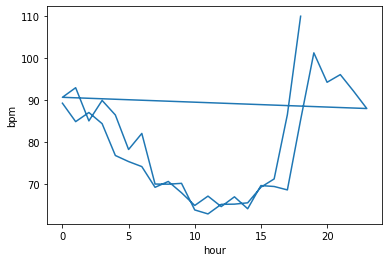

<Figure size 432x288 with 0 Axes>

In [243]:
# plot HR
fig1 = plt.gcf()
plt.plot(df['hour'], df['value'])
plt.xlabel('hour')
plt.ylabel('bpm')
plt.show()
plt.draw()
fig1.savefig('hr.png', dpi=100)
# store HR to firebase
imagePath = "hr.png"
imageBlob = bucket.blob(userID+"/DoctorReport/heartrate")
imageBlob.upload_from_filename(imagePath)
os.remove("hr.png")

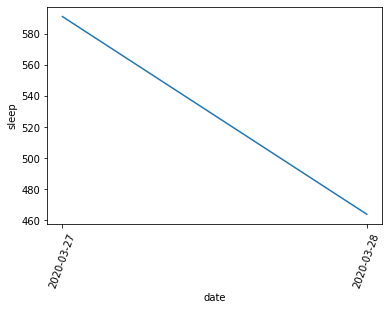

<Figure size 432x288 with 0 Axes>

In [244]:
# plot Sleep
# max plot a 15 date only 
fig1 = plt.gcf()
plt.plot(df['date'], df['sleep'])
plt.xlabel('date')
plt.ylabel('sleep')
plt.tick_params(axis='x', rotation=70)
plt.show()
plt.draw()
fig1.savefig('sleep.png', dpi=100)
# store HR to firebase
imagePath = "sleep.png"
imageBlob = bucket.blob(userID+"/DoctorReport/sleep")
imageBlob.upload_from_filename(imagePath)
#os.remove("sleep.png")